In [1]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 1/6/2022

import sys
import os
import numpy as np
import matplotlib
# matplotlib.use('pdf') # do this because environment does not have GUI backend
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math
import warnings
warnings.filterwarnings(action='once')

# !{sys.executable} -m pip install mpl-axes-aligner
import mpl_axes_aligner

# define function charge() that calculates the net charge of an amino acid sequence
def charge(AAseq):
    netCharge = 0
    for aa in AAseq:
        if (aa == 'K') or (aa == 'R'):
            netCharge += 1
        elif (aa == 'D') or (aa == 'E'):
            netCharge -= 1
    return netCharge

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

print('Packages imported')

Packages imported


### Spike DMS magnetic separation

#### Flow distribution featured in S2D

In [2]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/CoV_Spike-DMS_magsep_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['Citrine-A']>1e7, True, False)
df = df[df['Fraction']!='wash']
df['Fraction'] = pd.Categorical(df['Fraction'], categories=['pre-magsep', 'unbound', 'bound'])
aggdf = df.groupby(by=['Reporter', 'Fraction'], as_index=False).mean().sort_values(by=['Reporter', 'Fraction'])

aggdf

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Reporter,Fraction,Citrine-A,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,P1,P2,mCherry,Citrine_Act,Citrine_Rep
0,JT039,pre-magsep,1.054412e+07,8.410479e+08,6.841442e+08,6.083376e+08,1.922000e+08,1.0,1.0,0.989145,0.390846,0.175307
1,JT039,unbound,3.065545e+06,9.168728e+08,7.517073e+08,4.202893e+08,2.097228e+08,1.0,1.0,0.988093,0.260344,0.046341
2,JT039,bound,5.691359e+07,8.716052e+08,6.856850e+08,1.167236e+09,1.223641e+08,1.0,1.0,0.971979,0.974224,0.788722


In [3]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

tempdf = df.copy()
tempdf['mCitrine'] = np.log10(tempdf['Citrine-A'])

def plot_magsep(data_df, agg_df):
    ON = list(agg_df[agg_df['Reporter']=='JT039']['Citrine_Rep'])
    ON = [round(on*100, 1) for on in ON]
    OFF = [str(round(100-on, 1)) + '%' for on in ON]
    ON = [str(on) + '%' for on in ON]
    
    pal = sns.color_palette(['#70C632', '#70C632'])
    g = sns.FacetGrid(data=data_df[data_df['Reporter']=='JT039'],
                      col='Fraction', hue='Replicate', palette=pal,
                      aspect=0.92, height=1.35)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=1)
    g.set_titles(template='{col_name}')
    
    plt.xlim([4.5,9.5])
    plt.ylim([0, 2])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for i, ax, on, off in zip(range(6), g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.axvline(x=np.log10(1e7), ls=':', color='#333333', lw=1)
    
    plt.savefig('../Individual Figure Panels/Figure S2/CoV_Screens_Repression_magsep_kdeplot.png', dpi=1200)
    plt.close()
    
plot_magsep(tempdf, aggdf)

print('Complete')

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Complete


### Correlation of Spike DMS screen scores and validation % OFF
Note: screen endpoint was day 7 but validation endpoint was day 5 - should still correlate, but maybe not as well

In [14]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/CoV_Spike-DMS_validations_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['mCitrine-A']>1e7, True, False)
df.loc[df['Protein'].isna(), 'Protein'] = 'empty' 

aggdf = df.groupby(by=['Reporter', 'Condition', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Reporter,Condition,Construct,Protein,Replicate,Time,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,mCitrine-A,P1,P2,mCherry,mCitrine,Citrine_Rep
0,JT039,dox,CL370,V952D,Rep1,5.0,1.134139e+09,9.492517e+08,4.155812e+08,1.986517e+08,6.104151e+06,1.0,1.0,1.0,0.493943,0.108480
1,JT039,dox,CL370,V952D,Rep2,5.0,1.156483e+09,9.686910e+08,4.214060e+08,1.912794e+08,6.497818e+06,1.0,1.0,1.0,0.491286,0.121359
2,JT039,dox,CL371,N955A,Rep1,5.0,1.141145e+09,9.565219e+08,4.237984e+08,1.709009e+08,7.639519e+07,1.0,1.0,1.0,0.967742,0.923656
3,JT039,dox,CL371,N955A,Rep2,5.0,1.131166e+09,9.453130e+08,4.233301e+08,1.590398e+08,7.058903e+07,1.0,1.0,1.0,0.969822,0.925827
4,JT039,dox,CL372,K964P,Rep1,5.0,1.134786e+09,9.485116e+08,4.221255e+08,1.705422e+08,5.685569e+06,1.0,1.0,1.0,0.378661,0.096488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,JT039,nodox,CL385,WT,Rep2,5.0,1.080460e+09,9.096058e+08,3.850868e+08,1.763484e+08,7.204025e+07,1.0,1.0,1.0,0.971651,0.943302
68,JT039,nodox,CL386,MAX,Rep1,5.0,1.040176e+09,8.705960e+08,3.784941e+08,1.072417e+08,6.834917e+07,1.0,1.0,1.0,0.972828,0.943413
69,JT039,nodox,CL386,MAX,Rep2,5.0,1.071300e+09,9.043799e+08,3.760841e+08,1.132885e+08,7.261651e+07,1.0,1.0,1.0,0.974324,0.947027
70,JT039,nodox,JT126,empty,Rep1,5.0,1.065337e+09,8.870165e+08,4.046280e+08,1.768974e+08,6.636222e+07,1.0,1.0,1.0,0.972883,0.954505


In [15]:
constructDict = {'CL386':['Human', 'MAX', '', ''],
                 'JT126':['', 'empty', '', '']}

data = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/Spike_DMS-D7_combo.csv').rename(columns={'label':'Tile ID'})
key = pd.read_csv('../Flow Single-Cell Data - CSV/Spike-DMS_validations_key.csv')
key = key[['Construct', 'Tile ID']]
key = pd.merge(key, data, on='Tile ID', how='left')
key['Virus Abbreviation'] = 'SARS-CoV-2'
key['Protein'] = key['Tile ID'].str.split('_').str[1].str.split('-').str[-1]

for i in constructDict:
    key.loc[key['Construct']==i, 'Virus Abbreviation'] = constructDict[i][0]
    key.loc[key['Construct']==i, 'Protein'] = constructDict[i][1]

aggdfR = aggdf[aggdf['Reporter']=='JT039']
aggdfR = aggdfR[['Construct', 'Condition', 'Replicate', 'Citrine_Rep']]
aggdfR['Citrine OFF'] = 1 - aggdfR['Citrine_Rep']

normdf = aggdfR[aggdfR['Condition']=='dox']
normdf['Citrine OFF'] = normdf['Citrine OFF']*100
normdf = normdf.groupby(by=['Construct'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine OFF', 'std':'OFF std'})

keyR = pd.merge(key, normdf, on='Construct', how='left')
# keyR

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-15-891ae48dfdb8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine OFF'] = normdf['Citrine OFF']*100


0.9411764705882352 5.588937633072717e-08


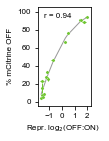

In [59]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
colorR = '#70C632' #'#23BEDB' #'#1BC6EE'

plt.figure(figsize=(1.4,2))
plotDF = keyR[(~keyR['Citrine OFF'].isna()) & (~keyR['Avg'].isna())].sort_values('Avg')
# plotDF = plotDF[~plotDF['Construct'].isin(['CL142', 'CL143', 'CL146'])]

sns.scatterplot(data=plotDF, x='Avg', y='Citrine OFF', color=colorR, s=10)
x = np.array(list(plotDF['Avg']))
y = np.array(list(plotDF['Citrine OFF']))
xerr = list(plotDF['Standard Error'])
yerr = list(plotDF['OFF std'])
for xi, yi, xe, ye in zip(list(x), list(y), xerr, yerr):
    plt.errorbar(x=xi, y=yi, xerr=xe, yerr=ye, color=colorR, lw=1)

def logistic(x, A, x0, k, off):
    return A/(1 + np.exp(-k*(x-x0)))+off
p, _ = curve_fit(logistic, x, y, p0=[100,6,1,0])
plt.plot(x, logistic(x, *p), color='#999999', lw=1, zorder=0)

coef, p = spearmanr(x, y)
print(coef, p)
plt.annotate('r = ' + str(round(coef, 2)), xy=(-1.4, 98.5), ha='left', va='top')
plt.xlabel('Repr. log$_2$(OFF:ON)  ')
plt.xticks([-1, 0, 1, 2])
plt.ylabel('% mCitrine OFF')
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S2/CoV_Spike-DMS_screen-validation_correlation.png', dpi=1200)


#### All validation flow distributions (not shown in manuscript)

In [19]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations(df, key):
    reporter = 'JT039'
    color = '#70C632' #'#23BEDB'
    yvar = 'Citrine OFF'
#         yvar = 'Citrine_Rep'
    cutoff = 1e7
    
    df = df[(df['Reporter']==reporter) & (df['Protein']!='MAX')]
    df['mCitrine'] = np.log10(df['mCitrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Avg', 'Virus Abbreviation', 'Protein', yvar]], how='left', on='Construct')
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']

    labeldf = df[['Construct', 'Virus Abbreviation', 'Protein', yvar, 'Avg']].drop_duplicates()
    labeldf['Order'] = np.where((labeldf['Protein']=='WT') | (labeldf['Protein']=='empty'),
                                np.where(labeldf['Protein']=='WT', '0', '9999'),
                                np.where(labeldf['Protein'].str.len()==7, labeldf['Protein'].str[2:5],
                                         np.where(labeldf['Protein'].str.len()==9, labeldf['Protein'].str[3:6],
                                                 labeldf['Protein'].str[1:4])))
    labeldf = labeldf.sort_values(by=['Order'], ascending=True)
    order = dict(zip(list(labeldf['Construct']), list(labeldf['Order'])))
    df['Order'] = df['Construct'].map(order)
    df = df.sort_values(by=['Order', 'Condition', 'Replicate'], ascending=[True, True, True])
        
    OFF = list(labeldf[yvar])
    OFF = [round(off, 1) for off in OFF]
    ON = [str(round(100-off, 1)) + '%' for off in OFF]
    OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    
    g = sns.FacetGrid(data=df, col='Protein', col_wrap=5,
                      hue='Condition-Replicate', palette=pal,
                      aspect=1, height=1.15)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    g.set_titles(template='{col_name}')
    plt.xlim([4.5,9.5])
    plt.ylim([0,4])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for i, ax, on, off in zip(range(len(g.axes.flat)), g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.grid(False)
    plt.savefig('../Individual Figure Panels/Figure S2/CoV_Spike-DMS_validations_kdeplot.png', dpi=1200)
    plt.close()

plot_validations(df, keyR)
print('Complete')

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-8d4df4a6bf9f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Complete


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Complete


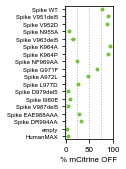

In [46]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validation_summary(df):
    reporter = 'JT039'
    color = '#70C632'
    meancol = 'Citrine OFF'
    stdcol = 'OFF std'
    xlabel = '% mCitrine OFF'
    cutoff = 1e7
    
    df = df[~df[meancol].isna()].sort_values(by='Avg', ascending=False)
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Order'] = np.where((df['Protein']=='WT') | (df['Protein']=='empty'),
                                np.where(df['Protein']=='WT', '0', '9999'),
                                np.where(df['Protein'].str.len()==7, df['Protein'].str[2:5],
                                         np.where(df['Protein'].str.len()==9, df['Protein'].str[3:6],
                                                 df['Protein'].str[1:4])))
    df = df.sort_values(by=['Order'], ascending=True)
    
    df['Protein'] = np.where(df['Virus Abbreviation']=='SARS-CoV-2', 'Spike ' + df['Protein'],
                             df['Virus Abbreviation'] + df['Protein'])
    samplelist = list(df['Protein'])
    ticklist = list(range(len(samplelist)))
    meanlist = list(df[meancol])
    stdlist = list(df[stdcol])
    
    fig, ax = plt.subplots(figsize=(1.8, 2.4))
    for s, t, m, sd in zip(samplelist, ticklist, meanlist, stdlist):
        ax.plot(m, t, marker='o', markersize=3, color=color)
        ax.errorbar(x=m, y=t, xerr=sd, lw=1, color=color)
    ax.set_xlabel(xlabel)
    ax.set_xticks(ticks=[0, 50, 100])
    for x in range(0, 101, 25):
        ax.axvline(x=x, ls=':', lw=1, color='#BBBBBB', zorder=-10)
    ax.set_yticks(ticks=ticklist)
    ax.set_yticklabels(labels=samplelist, fontsize=6)
    ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S2/Spike-DMS_Repression_validation_summary.png', dpi=1200)

plot_validation_summary(keyR)
print('Complete')

### FLAG expression/stability data for validated tiles

In [47]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/CoV_Spike-DMS_validations_FLAG_stability_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
aggdf = df.groupby(by=['Reporter', 'Construct', 'Protein', 'Replicate',], as_index=False).mean()
normdf = aggdf.copy()
print('Complete')

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Complete


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


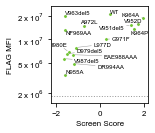

In [34]:
from adjustText import adjust_text

sumDFtoSave = normdf.groupby(by=['Reporter', 'Construct', 'Protein']).mean().reset_index()
sumDFtoSave['FLAG'] = np.log10(sumDFtoSave['Alexa 647-A'])
sumDFtoSave = sumDFtoSave[['Reporter', 'Construct', 'Protein', 'FLAG']]
blankFLAG = list(sumDFtoSave[(sumDFtoSave['Reporter']=='JT039') & (sumDFtoSave['Protein']=='control')]['FLAG'])
sumDFtoSave = sumDFtoSave[~sumDFtoSave['Construct'].isin(['-', 'CL214'])]

screenScores = pd.read_csv('../Flow Single-Cell Data - CSV/Spike-DMS_validations_key.csv')
screenScores['Protein'] = screenScores['Tile ID'].str.split('_').str[1].str.split('-').str[-1]
constrList = list(screenScores['Construct'])
protList = list(screenScores['Protein'])
RepScoreList = list(screenScores['Avg'])
constrProtMap = dict(zip(constrList, protList))
constrRepScoreMap = dict(zip(constrList, RepScoreList))
sumDFtoSave['Screen Score'] = sumDFtoSave['Construct'].map(constrRepScoreMap)
sumDFtoSave['Protein'] = sumDFtoSave['Construct'].map(constrProtMap)
plotDF = sumDFtoSave.dropna().sort_values(by='Screen Score')

plt.figure(figsize=(2.2,1.9))
sns.scatterplot(data=plotDF, x='Screen Score', y='FLAG', color='#70C632', s=10)
plt.axhline(y=blankFLAG, ls=':', color='#999999', lw=1)
labels = list(plotDF['Protein'])
xvals = list(plotDF['Screen Score'])
yvals = list(plotDF['FLAG'])

plt.xlim(-2.2, 2.2)
plt.ylabel('FLAG MFI')
plt.ylim(np.log10(1.5e6), np.log10(2.7e7))
yticks = [2e6, 5e6, 1e7, 2e7]
yticks = [np.log10(y) for y in yticks]
plt.yticks(yticks, ['2 x 10$^6$', '5 x 10$^6$', '1 x 10$^7$', '2 x 10$^7$'])
plt.tight_layout()
# plt.yscale('log')

texts = []
for x, y, l in zip(xvals, yvals, labels):
    texts.append(plt.text(x, y, l, fontsize=6))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#999999', lw=0.5)) #, force_objects=(1.2, 1.5))
# plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S2/CoV_Spike-DMS_validations_FLAG-MFI_vs_screen-score.png', dpi=1200)


### Screen analysis

#### Prepare dataframe

In [4]:
df = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/Spike_DMS-D7_combo.csv')
tileInfo = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/SARS-CoV-2_Spike_DMS_codon-opt-proteins_oligos.csv')

df.rename(columns={'label':'Oligo ID'}, inplace=True)
df = pd.merge(df, tileInfo, how='inner', on='Oligo ID').drop(columns=['Fragment Length', 'Pre-dummy Length', 'Left Dummy', 'Right Dummy'])
df.sort_values(by='Avg', inplace=True)

# add tile net charge
chargeList = [charge(seq) for seq in list(df['Protein Sequence'])]
df['Net Charge'] = chargeList
WTscore = np.mean(list(df[df['Name'].str.contains('SARS2-WT')]['Avg']))
WTstd = np.std(list(df[df['Name'].str.contains('SARS2-WT')]['Avg']))
print(WTscore, WTstd)
print(str(list(df.loc[df['Name'].str.contains('SARS2-WT_4')]['Protein Sequence'])[0]))

0.46415224550000006 0.12342677972253942
TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Screen reproducibility

#### Scatterplot featured in Fig. S1E

<ipython-input-5-8924d18f50f9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfscatter['Element Type'] = np.where(dfscatter['Name'].str.contains('random'), 'random', 'DMS')


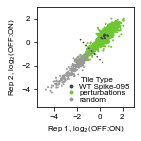

In [5]:
import matplotlib.patches as mpatches
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

dfscatter = df[((df['countsOFF_R1'] + df['countsON_R1'])>=50) & ((df['countsOFF_R2'] + df['countsON_R2'])>=50)]
dfrandom = dfscatter[dfscatter['Name'].str.contains('random')]
random_mean = np.mean(list(dfrandom['Avg']))
random_std = np.std(list(dfrandom['Avg']))
cutoff = random_mean + 2*random_std
dfscatter['Element Type'] = np.where(dfscatter['Name'].str.contains('random'), 'random', 'DMS')
dfscatter['Element Type'] = np.where(dfscatter['Name'].str.contains('fiducial'), 'fiducial', dfscatter['Element Type'])
dfscatter['Element Type'] = np.where(dfscatter['Name'].str.contains('SARS2-WT'), 'WT', dfscatter['Element Type'])
colors = ['#70C632', '#444444', '#999999']
pal = sns.color_palette(colors)
plt.figure(figsize=(2, 2))
sns.scatterplot(data=dfscatter[dfscatter['Element Type']!='fiducial'].sort_values(by='Element Type', ascending=True),
                x='R1', y='R2', hue='Element Type', linewidth=0, s=4, palette=pal)
plt.xlabel('Rep 1, log$_2$(OFF:ON)')
plt.ylabel('Rep 2, log$_2$(OFF:ON)')
line_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label='WT Spike-095', markerfacecolor=colors[1], markersize=10),
                 Line2D([0], [0], marker='o', color='#FFFFFF', label='perturbations', markerfacecolor=colors[0], markersize=10),
                 Line2D([0], [0], marker='o', color='#FFFFFF', label='random', markerfacecolor=colors[2], markersize=10)]
plt.legend(handles=line_elements, loc='lower right', bbox_to_anchor=(1, 0), markerscale=0.5, handletextpad=0,
           labelspacing=0, title='Tile Type', frameon=False, borderpad=0)

plt.plot([cutoff-1, cutoff+1], [cutoff+1, cutoff-1], ls=':', color='#444444')
plt.ylim(-5.5, 3)
plt.yticks([-4, -2, 0, 2])
plt.xlim(-5.5, 3)
plt.xticks([-4, -2, 0, 2])
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S2/Spike_DMS_reproducibility.png', dpi=1200)


In [85]:
print(cutoff)

-0.7333324303363442


### Distribution of screen score standard deviations for multiple encodings of library members

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-73-a31187821d49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dferror['Mutation'] = dferror['Name'].str.split('_').str[:-1].str.join('_')


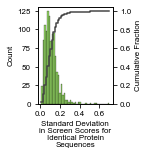

In [73]:
dferror = df[~df['Name'].str.contains('fiducial|random')]
dferror['Mutation'] = dferror['Name'].str.split('_').str[:-1].str.join('_')
dferror = dferror.groupby('Mutation').std()

fig, ax = plt.subplots(figsize=(2.1, 2.2))
sns.histplot(data=dferror, x='Avg', ax=ax, color='#70C632')
ax2 =ax.twinx()
sns.histplot(data=dferror, x='Avg', cumulative=True, ax=ax2, color='#444444', element='step', fill=False, stat='density')
ax.set_xlabel('Standard Deviation\nin Screen Scores for\nIdentical Protein\nSequences')
ax.set_xticks([0, 0.2, 0.4, 0.6])
ax.set_ylabel('Count')
ax2.set_ylabel('Cumulative Fraction')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S2/Spike_DMS_histogram_std-devs.png', dpi=1200)


### Comparison of WT strengths

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-74-b388aeee1b55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WT['Virus'] = df_WT['Name'].str.split('_').str[0].str.split('-').str[0]


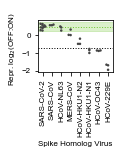

In [74]:
virDict = {'CVH22':'HCoV-229E', 'CVHOC':'HCoV-OC43', 'CVHN1':'HCoV-HKU1-N1', 'CVHN2':'HCoV-HKU1-N2',
           'MERS1':'MERS-CoV', 'CVHNL':'HCoV-NL63', 'CVHSA':'SARS-CoV', 'SARS2':'SARS-CoV-2'}
df_WT = df[df['Type']=='WT']
df_WT['Virus'] = df_WT['Name'].str.split('_').str[0].str.split('-').str[0]
df_WT['Virus Full'] = df_WT['Virus'].map(virDict)
# df_WT = df_WT.groupby(by=['Virus', 'Protein Sequence']).mean().reset_index().sort_values(by=['Avg'])
plt.figure(figsize=(1.8,2))
sns.swarmplot(data=df_WT.sort_values('Avg', ascending=False), x='Virus Full', y='Avg', s=2.5, color='#444444')
plt.axhspan(ymin=(WTscore-2*WTstd), ymax=(WTscore+2*WTstd), color='#70C632', alpha=0.25, zorder=-2)
plt.axhline(y=WTscore, color='#70C632', ls=':', lw=1)
plt.axhline(y=cutoff, color='#000000', ls=':', lw=1)
plt.xlabel('Spike Homolog Virus')
plt.xticks(rotation=90)
plt.ylabel('Repr. log$_2$(OFF:ON)   ')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S2/Spike_DMS_WT-homolog-scores.png', dpi=1200)

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-75-e027249fb6a7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_del['Mutation'] = df_del['Name'].str.split('_').str[0].str.split('-').str[-1]


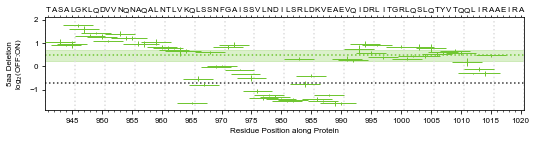

In [75]:
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

WT_seq = 'TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA'
xrange = list(range(941, 1022, 5))
xticks = list(range(941, 1021, 1))
xticks_mod = [x - 0.5 for x in xticks]
color = '#70C632'

df_del = df[df['Type']=='delete5aa']
df_del['Mutation'] = df_del['Name'].str.split('_').str[0].str.split('-').str[-1]
df_del['Position'] = df_del['Mutation'].str[:-4].str[1:].astype(int)
df_del = df_del.groupby(by=['Mutation', 'Position', 'Protein Sequence']).mean().reset_index().sort_values(by='Position')

# lists for annotations
delx = [p + 2 for p in list(df_del['Position'])]
dely = list(df_del['Avg'])
delyerr = list(df_del['Standard Error'])

fig, ax = plt.subplots(2, 1, figsize=(7.5,2), gridspec_kw={'height_ratios':[0.5, 9.5]}, sharex=False)

# plot sequence on top with critical substitutions highlighted
ax[0].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(MultipleLocator(1))
ax[0].xaxis.set_ticklabels('')
ax[0].set_yticks([])
sns.despine(left=True, bottom=True, ax=ax[0])
sub_nonhit = []
for x, aa in zip(xticks, WT_seq):
    if x in sub_nonhit:
        ax[0].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=8, color='#EA7063')
    else:
        ax[0].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=8)
                
# plot deletion scan data, with WT scores as horizontal span
ax[1].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_minor_locator(MultipleLocator(1))
ax[1].set_ylim(-1.9, 2.1)
ax[1].axhline(y=cutoff, color='#333333', ls=':', zorder=-5)
ax[1].axhline(y=WTscore, color=color, ls=':', zorder=-5)
ax[1].axhspan(ymax=(WTscore-2*WTstd), ymin=(WTscore+2*WTstd), color=color, alpha=0.25, zorder=0)
        
for x in xrange:
    ax[1].axvline(x=x-0.5, color='#DDDDDD', ls=':')
        
plotdf_del = pd.DataFrame({'X':delx, 'Y':dely})
# sns.scatterplot(data=plotdf_del, x='X', y='Y', color=color, ax=ax[1])
for x, y, ye in zip(delx, dely, delyerr):
    ax[1].errorbar(x, y, xerr=2.5, yerr=ye, color=color, zorder=100, lw=1)
       
ax[1].set_xlabel('Residue Position along Protein')
ax[1].set_ylabel('5aa Deletion\nlog$_2$(OFF:ON)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('../Individual Figure Panels/Figure S2/CoV_Spike-DMS_deletion.png', dpi=1200)

### Single substitution data

In [78]:
df_singlesub = df[df['Type']=='singlesub'].drop(columns=['countsOFF_R1', 'countsON_R1', 'countsOFF_R2', 'countsON_R2'])
df_singlesub['Mutation'] = df_singlesub['Name'].str.split('_').str[0]

score_std = list(df_singlesub.groupby('Mutation').std()['Avg'])
df_singlesub = df_singlesub.groupby(by=['Mutation', 'Protein Sequence']).mean().reset_index()
df_singlesub['StDev'] = score_std

df_singlesub['Original Residue'] = df_singlesub['Mutation'].str.split('-').str[-1].str[0]
df_singlesub['Mutation Position'] = df_singlesub['Mutation'].str.split('-').str[-1].str[1:].str[:-1].astype(int)
df_singlesub['Residue'] = df_singlesub['Original Residue'] + df_singlesub['Mutation Position'].astype(str)
df_singlesub['New Residue'] = df_singlesub['Mutation'].str[-1]
df_singlesub['New Res Type'] = np.where(df_singlesub['New Residue'].str.contains('D|E'), 'acidic', '-')
df_singlesub['New Res Type'] = np.where(df_singlesub['New Residue'].str.contains('K|R'), 'basic', df_singlesub['New Res Type'])
df_singlesub['New Res Type'] = np.where(df_singlesub['New Residue'].str.contains('F|W|Y'), 'aromatic', df_singlesub['New Res Type'])
df_singlesub['New Res Type'] = np.where(df_singlesub['New Residue'].str.contains('S|T|N|Q'), 'polar', df_singlesub['New Res Type'])
df_singlesub['New Res Type'] = np.where(df_singlesub['New Residue'].str.contains('A|V|I|L|M'), 'non-polar', df_singlesub['New Res Type'])
df_singlesub = df_singlesub.sort_values(by=['Mutation Position', 'New Residue'], ascending=True)
df_singlesub

,Mutation,Protein Sequence,R1,R2,Avg,Standard Error,Net Charge,StDev,Original Residue,Mutation Position,Residue,New Residue,New Res Type
646,SARS2-T941A,AASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK...,0.421643,0.482421,0.452032,0.043283,1,0.137433,T,941,T941,A,non-polar
647,SARS2-T941C,CASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK...,0.227196,0.437085,0.332140,0.108338,1,0.029044,T,941,T941,C,-
648,SARS2-T941D,DASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK...,0.672838,0.536155,0.604497,0.068341,0,0.057937,T,941,T941,D,acidic
649,SARS2-T941E,EASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK...,0.644107,0.549821,0.596964,0.081405,0,0.120646,T,941,T941,E,acidic
650,SARS2-T941F,FASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDK...,0.192724,0.345861,0.269292,0.180272,1,0.175129,T,941,T941,F,aromatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,SARS2-I980S,TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDSLSRLDK...,0.445253,0.332266,0.388759,0.057183,1,0.086376,I,980,I980,S,polar
224,SARS2-I980T,TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDTLSRLDK...,0.308182,0.446857,0.377520,0.100009,1,0.053585,I,980,I980,T,polar
225,SARS2-I980V,TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDVLSRLDK...,0.583880,0.565664,0.574772,0.075063,1,0.120849,I,980,I980,V,non-polar
226,SARS2-I980W,TASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDWLSRLDK...,-0.548634,-0.657099,-0.602867,0.062262,1,0.033085,I,980,I980,W,aromatic


20 40


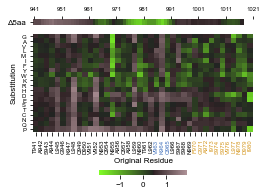

In [84]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# show as heatmap
# amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
# amino_acids = ['G', 'A', 'V', 'L', 'I', 'P', 'M', 'F', 'Y', 'W', 'S', 'T', 'C', 'N', 'Q', 'D', 'E', 'R', 'H', 'K']
amino_acids = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']
# amino_acids = ['W', 'P', 'D', 'E', 'K', 'R', 'F', 'M', 'Y', 'C', 'V', 'I', 'L', 'T', 'N', 'H', 'Q', 'S', 'A', 'G']
# amino_acids = ['P', 'D', 'E', 'K', 'R', 'H', 'N', 'Q', 'S', 'T', 'Y', 'W', 'F', 'L', 'I', 'V', 'A', 'G', 'C', 'M']
aminoDict = {'A':'non-polar', 'C':'-', 'D':'acidic', 'E':'acidic', 'F':'aromatic', 'G':'-', 'H':'-', 'I':'non-polar',
             'K':'basic', 'L':'non-polar', 'M':'non-polar', 'N':'polar', 'P':'-', 'Q':'polar', 'R':'basic', 'S':'polar',
             'T':'polar', 'V':'non-polar', 'W':'aromatic', 'Y':'aromatic'}
colorDict = {'non-polar':'#f6b75e', '-':'#999999', 'acidic':'#f06724', 'aromatic':'#f167ae', 'basic':'#347be0', 'polar':'#9ec9f9'}
colorList = [colorDict[aminoDict[res]] for res in amino_acids]

df_labels = df_singlesub[['Mutation Position', 'Residue', 'Original Residue']].groupby(by=['Residue', 'Original Residue']).mean().sort_values(by='Mutation Position').reset_index()
labels = list(df_labels['Residue'])

origRes = list(df_singlesub['Original Residue'])
fullRes = list(df_singlesub['Residue'])
newRes = list(df_singlesub['New Residue'])
score = list(df_singlesub['Avg'])

dfmat = pd.DataFrame(index=amino_acids, columns=labels)
dfmat = dfmat.fillna(np.nan)
print(len(amino_acids), len(labels))

for i in range(len(fullRes)):
    dfmat.loc[origRes[i], fullRes[i]] = WTscore
    dfmat.loc[newRes[i], fullRes[i]] = score[i]

df_del2 = df_del[['Position', 'Avg']]
for i in range(941,1021):
    if i not in list(df_del2['Position']):
        df_del2.loc[len(df_del2.index)] = [i, np.nan]
df_del2 = df_del2.sort_values(by='Position')
delx = list(df_del2['Position'])
dely = list(df_del2['Avg'])
dely2 = []
for i in range(len(dely)):
    if i < 5:
        chunk = dely[:i+1]
    elif i == (len(dely) - 1):
        chunk = [dely[-1]]
    elif i > (len(dely) - 3):
        chunk = dely[i:]
    else:
        chunk = dely[i-4:i+1]
        
    chunk = [j for j in chunk if math.isnan(j) == False] 
        
    if len(chunk) > 1:
        dely2.append(np.mean(chunk))
    elif len(chunk) == 1:
        dely2.append(chunk[0])
    else:
        dely2.append(np.nan)

delx2 = delx
delx2 = [int(x) for x in delx2]
dely2 = dely2

mat = pd.DataFrame(index=delx2, columns=['deletion'])
mat['deletion'] = dely2

fig, ax = plt.subplots(2, 1, figsize=(3.75, 2.85), gridspec_kw={'height_ratios':[0.4, 9.6]}, sharex=False)

sns.heatmap(data=mat.T, cbar=False, center=WTscore, vmin=-1.9, vmax=1.9,
            cmap=sns.diverging_palette(120, 360, s=100, l=90, as_cmap=True, center='dark'), ax=ax[0])

ax[0].tick_params(axis='x', which='major', labelsize=6, labelbottom=False, bottom=False, top=True, labeltop=True)
ax[0].set_xticks(ticks=[i - 940.5 for i in range(941, 1022, 10)])
ax[0].set_xticklabels(labels=range(941, 1022, 10))#, rotation=90)
ax[0].yaxis.set_major_locator(ticker.FixedLocator([0.5]))
ax[0].set_yticklabels(labels=['\u03945aa'])

sns.heatmap(data=dfmat, mask=dfmat.isnull(), center=WTscore, vmin=-1.9, vmax=1.9,
            cmap=sns.diverging_palette(120, 360, s=100, l=90, as_cmap=True, center='dark'),
            cbar_kws={'orientation':'horizontal', 'shrink':0.4, 'pad':0.24}, ax=ax[1])

yticks = [y + 0.5 for y in range(20)]
ax[1].yaxis.set_major_locator(ticker.FixedLocator(yticks))
ax[1].set_yticks(ax[1].get_yticks())
ax[1].set_yticklabels(labels=amino_acids, rotation=0, fontsize=6)

xticks = [x + 0.5 for x in range(40)]
ax[1].xaxis.set_major_locator(ticker.FixedLocator(xticks))
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(labels=labels, rotation=90, fontsize=6, va='top')

# ax.yaxis.set_minor_locator(MultipleLocator(1))
ax[1].set_xlabel('Original Residue')
ax[1].set_ylabel('Substitution')

c1 = '#4473bd'
c2 = '#d69a26'

to_color = {'V963':c1, 'K964':c1, 'Q965':c1, 'F970':c2, 'G971':c2, 'A972':c2, 'I973':c2,
            'S974':c2, 'S975':c2, 'V976':c2, 'L977':c2, 'N978':c2, 'D979':c2, 'I980':c2}

for xtick in ax[1].get_xticklabels():
    if xtick.get_text() in to_color:
        xtick.set_color(to_color[xtick.get_text()])

# for ytick, label, color in zip(ax.get_yticklabels(), amino_acids, colorList):
#     ytick.set_label(label)
#     ytick.set_color(color)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.savefig('../Individual Figure Panels/Figure 2/CoV_Spike-DMS_single-subs_heatmap.png', dpi=1200)


### Detailed file

In [16]:
spike = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/Spike_DMS-D7_combo.csv')
tileInfo = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/SARS-CoV-2_Spike_DMS_codon-opt-proteins_oligos.csv')

spike = spike.rename(columns={'label':'Oligo ID'})
spike = pd.merge(spike, tileInfo, how='inner', on='Oligo ID').drop(columns=['Fragment Length', 'Pre-dummy Length', 'Left Dummy', 'Right Dummy'])
spike = spike.sort_values(by='Avg')
spike['Type'] = np.where(spike['Name'].str.contains('random'), 'random', 'substitution')
spike['Type'] = np.where(spike['Name'].str.contains('fiducial'), 'fiducial', spike['Type'])
spike['Type'] = np.where(spike['Name'].str.contains('WT'), 'WT', spike['Type'])
spike['Type'] = np.where(spike['Name'].str.contains('AA'), 'doubleAA', spike['Type'])
spike['Type'] = np.where(spike['Name'].str.contains('AAA'), 'tripleAA', spike['Type'])
spike['Type'] = np.where(spike['Name'].str.contains('del5'), 'deletion', spike['Type'])
spike.to_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/Spike_DMS-D7_combo_detailed.csv', index=False)
spike

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Oligo ID,R1,countsOFF_R1,countsON_R1,R2,countsOFF_R2,countsON_R2,Avg,Standard Error,Name,Protein Sequence,Type,DNA Sequence,Oligo Sequence
3249,Spike-DMS_fiducial_042,-4.650038,49,1330,-4.188409,106.0,1669.0,-4.419224,0.230814,fiducial_042,EYGLTDNVERIVENEKINAEKSSKQKVDLQSLPTRAYLDQTVVPIL...,fiducial,GAGTACGGCCTGACCGACAACGTGGAGAGAATCGTGGAGAACGAGA...,GAGCCTTATGATTTCCCGcCGTCTCCctccGAGTACGGCCTGACCG...
3470,Spike-DMS_random-set01_0667,-4.740450,59,1705,-4.037106,152.0,2155.0,-4.388778,0.351672,random-set01_0667,YLTGYVSPNRSRQYDLKSNARPEGDKPRRGAETGQTDNTQRTTETN...,random,TACCTTACAGGCTACGTGTCCCCTAACAGGTCCAGACAGTATGACT...,GAGCCTTATGATTTCCCGcCGTCTCCctccTACCTTACAGGCTACG...
3236,Spike-DMS_fiducial_029,-4.366270,27,602,-4.265857,44.0,731.0,-4.316063,0.050206,fiducial_029,ASMPPTPEAQGPILFEDLAVYFSQEECVTLHPAQRSLSKDGTKESL...,fiducial,GCCAGCATGCCCCCCACCCCCGAGGCCCAGGGCCCCATCCTGTTCG...,GAGCCTTATGATTTCCCGcCGTCTCCctccGCCAGCATGCCCCCCA...
3333,Spike-DMS_random-set01_0105,-4.221094,173,3488,-4.279522,276.0,4629.0,-4.250308,0.029214,random-set01_0105,NQIMGTSLPLTAELRPKPCSQFQGLGLSLAHMHPRPDAYRVRKRQL...,random,AATCAGATCATGGGAACATCCTTGCCCTTGACGGCAGAGCTTCGGC...,GAGCCTTATGATTTCCCGcCGTCTCCctccAATCAGATCATGGGAA...
3505,Spike-DMS_random-set01_0777,-4.340247,176,3854,-4.134393,342.0,5187.0,-4.237320,0.102927,random-set01_0777,FSPIPRSPYMLNPATAEPHCAGCVDAKNILEPTVVCDLSACGDGTT...,random,TTTTCACCCATTCCGAGGTCTCCATACATGCTGAACCCAGCTACTG...,GAGCCTTATGATTTCCCGcCGTCTCCctccTTTTCACCCATTCCGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,Spike-DMS_fiducial_074,4.423250,258,13,4.077945,352.0,18.0,4.250598,0.172652,fiducial_074,TKPKSDILKDPPSEANSIQSANATTKTSETNHTSRPRLKNVDRSTA...,fiducial,ACTAAGCCTAAGTCTGATATTTTGAAGGATCCTCCTTCTGAGGCTA...,GAGCCTTATGATTTCCCGcCGTCTCCctccACTAAGCCTAAGTCTG...
3304,Spike-DMS_fiducial_097,3.674499,437,37,4.942244,712.0,20.0,4.308371,0.633873,fiducial_097,DAKSLTAWSRTLVTFKDVFVDFTREEWKLLDTAQQIVYRNVMLENY...,fiducial,GACGCCAAGAGCCTGACCGCCTGGAGCAGAACCCTGGTGACCTTCA...,GAGCCTTATGATTTCCCGcCGTCTCCctccGACGCCAAGAGCCTGA...
3212,Spike-DMS_fiducial_005,4.573942,705,32,4.483026,984.0,38.0,4.528484,0.045458,fiducial_005,KDKVEKEKSEKETTSKKNSHKKTRPRLKNVDRSSAQHLEVTVGDLT...,fiducial,AAGGACAAGGTGGAGAAGGAGAAGAGCGAGAAGGAGACCACCAGCA...,GAGCCTTATGATTTCCCGcCGTCTCCctccAAGGACAAGGTGGAGA...
3211,Spike-DMS_fiducial_004,4.397865,351,18,5.562627,602.0,11.0,4.980246,0.582381,fiducial_004,AEAFGDSEEDGEDVFEVEKILDMKTEGGKVLYKVRWKGYTSDDDTW...,fiducial,GCCGAGGCCTTCGGCGACAGCGAGGAGGACGGCGAGGACGTGTTCG...,GAGCCTTATGATTTCCCGcCGTCTCCctccGCCGAGGCCTTCGGCG...
